**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch 
import torch.nn as nn                                 # used for neuran network
import torch.optim as optim                           #used for optimiser
from torchvision.datasets import FashionMNIST 
from torch.utils.data import DataLoader               # used for DataLoading in batches as we are using Min Batch GD    
import torchvision.transforms as transforms           # used preprocessing the data
from torchvision.utils import make_grid               #

import os
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

**Loading Dataset**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), #converts PIL images to tensors
                                transforms.Normalize(mean=0, std=1)]) # normalize the pixel values from range [0,255] to [0,1]
train_dataset = FashionMNIST(train=True, transform = transform, root=os.getcwd(), download=True)
test_dataset = FashionMNIST(train=False, transform = transform, root=os.getcwd(), download=True)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...



Done!


In [ ]:
print(len(train_dataset),len(test_dataset))

60000 10000


In [ ]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4) 
test_loader = DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=4)

**Building Neural Network**

In [ ]:
# for using in GPU
device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def evaluate_on_gpu(model, dataloader):
  with torch.no_grad():
    total, correct = 0, 0

    for batch in dataloader:
      images, labels = batch
      images,labels = images.to(device), labels.to(device)

      out_probs = model(images)
      out_labels=torch.argmax(out_probs,axis=1)
      total += labels.size(0)
      correct += torch.sum(labels == out_labels).item()
  
  return 100 * correct/total
def train_on_gpu(model, loss_criterion, optimizer,train_loader,test_loader,epochs=100):
  hist = {'loss':[],
          'train_acc':[],
          'test_acc':[]}
  min=99
  for epoch_num in tqdm(range(1,epochs+1),desc='Training', total=epochs):
    losses = []
    for batch in train_loader:
      images, labels = batch
      images,labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      out = model(images)
      loss = loss_criterion(out,labels)
      losses.append(loss.item())
      loss.backward()
      optimizer.step()
    hist['loss'].append(np.array(losses).mean())
    train_acc = evaluate_on_gpu(model,train_loader)
    test_acc = evaluate_on_gpu(model,test_loader)
    hist['train_acc'].append(train_acc)
    hist['test_acc'].append(test_acc)
    if min > np.array(losses).mean():
      min = np.array(losses).mean()
      e=epoch_num
      atr = train_acc
      ate = test_acc
      torch.save(model.state_dict(),'model_weight.pth')  # Saving model by weight

   
  fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist['loss'],label='Loss')
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs vs Loss')
  ax[1].plot(range(1,epochs+1),hist['train_acc'], 'b-',label='Training accuracy')
  ax[1].plot(range(1,epochs+1),hist['test_acc'], 'm-',label='Testing accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs vs Accuracy')
  plt.show()
  #printing all values in hist dict and even the min loss, train accuracy and test accuracy
  print('Loss:\n',hist['loss'])
  print('train_acc:\n',hist['train_acc'])
  print('test_acc:\n',hist['test_acc'])
  print('\n\nLowest loss value: ',min)
  print('\nTrain_acc: ',atr)
  print('\nTest_acc: ',ate)
  return model

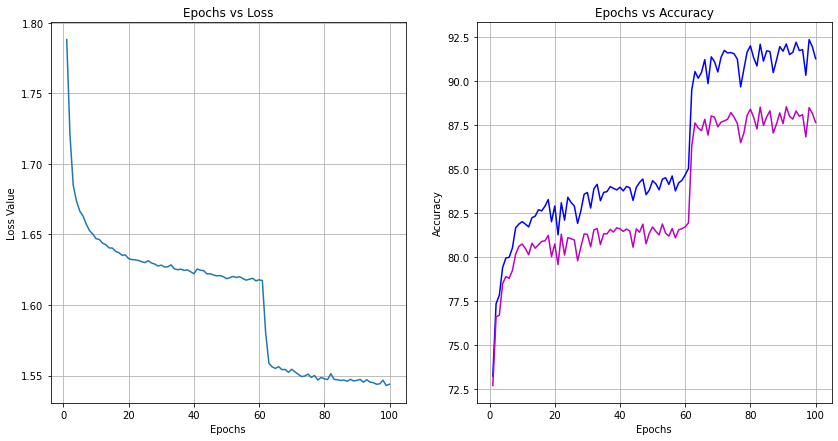

Loss:
 [1.7880255241394043, 1.7205788376490274, 1.6846805325826009, 1.673626338704427, 1.6665645451863607, 1.6629664436976115, 1.6572538319905599, 1.652640493520101, 1.6502565329869587, 1.6469836986541748, 1.6463691217422485, 1.6437913572311402, 1.6427235116322836, 1.6404221915562947, 1.6402916763305664, 1.637972666867574, 1.6370313206354776, 1.6352191289901734, 1.6354356826782226, 1.632778208287557, 1.6321856187184651, 1.6319504332224528, 1.6315546834309895, 1.6306283040364584, 1.630018156369527, 1.6313576532999674, 1.6297344338099162, 1.6289515740712484, 1.6276345881144205, 1.6281973389307658, 1.6269025330861409, 1.6270305669784546, 1.6284488578160603, 1.625580874379476, 1.6249869563420614, 1.625391369565328, 1.6245151072820028, 1.6248167520523071, 1.6235710271835326, 1.6221397676467895, 1.6254994368871054, 1.624640645281474, 1.6243132093429566, 1.622030998357137, 1.6221180873235066, 1.621226140975952, 1.620677074877421, 1.620813914680481, 1.6201090710957846, 1.618589307085673, 1.619

In [ ]:
class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()
        self.net = nn.Sequential(
            # input layer flatten
            nn.Flatten(),
            # 1st hidden layer
            nn.Linear(784, 650),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(650, 420),
            nn.ReLU(),
            # 3rd hidden layer
            nn.Linear(420, 360),
            nn.ReLU(),
            # 4rd hidden layer
            nn.Linear(360, 230),
            nn.ReLU(),
            # output layer
            nn.Linear(230,10),
            nn.Softmax(dim=1),
        )
    
    def forward(self, X):
        outs = self.net(X)
        return outs

model=NNet().to(device)
loss_criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.0001)
model=train_on_gpu(model,loss_criterion,optimizer,train_loader,test_loader)

**Loading Sved Model**

In [ ]:
model.load_state_dict(torch.load('model_weight.pth'))
model
model.eval() # training mode

NNet(
  (net): Sequential(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=650, bias=True)
    (2): ReLU()
    (3): Linear(in_features=650, out_features=420, bias=True)
    (4): ReLU()
    (5): Linear(in_features=420, out_features=360, bias=True)
    (6): ReLU()
    (7): Linear(in_features=360, out_features=230, bias=True)
    (8): ReLU()
    (9): Linear(in_features=230, out_features=10, bias=True)
    (10): Softmax(dim=1)
  )
)

**Accuracy Score of Train and Test Datasets**

In [ ]:
acc_train = evaluate_on_gpu(model,train_loader)
print('Training Accuracy: ',acc_train)
acc_test = evaluate_on_gpu(model,test_loader)
print('Testing Accuracy',acc_test)

Training Accuracy:  91.94666666666667
Testing Accuracy 88.16


**Ploting images in test batch**

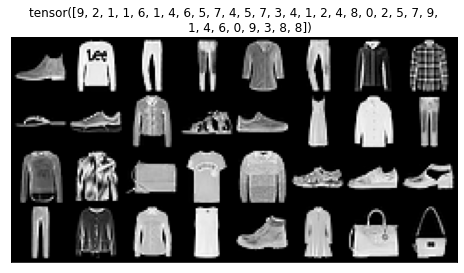

In [ ]:
def plot_images(batch):
  img_grid = make_grid(batch[0],nrow=8) # batch[0] input values
  img_np = img_grid.numpy() # as matplot only works on numpy we must convert to numpy
  img_np = np.transpose(img_np, (1,2,0)) # from [channels,height, width] to [height,width,channel]
  plt.figure(figsize=(8,8)) 
  plt.imshow(img_np)
  plt.title(batch[1])
  plt.xticks([])
  plt.yticks([])
  plt.show()
test_iterator = iter(test_loader)
test_batch = next(test_iterator)
plot_images(test_batch)

**Prediction by model on test batch**

In [ ]:
model_p = NNet()
pred_batch=model_p(test_batch[0])
print(pred_batch.size())

torch.Size([32, 10])


In [ ]:
pred_labels=torch.argmax(pred_batch,axis=1)
print(pred_labels)

tensor([1, 5, 5, 5, 1, 5, 1, 1, 1, 1, 5, 1, 1, 5, 5, 5, 1, 5, 1, 5, 5, 5, 5, 1,
        5, 1, 5, 5, 1, 5, 5, 1], grad_fn=<NotImplemented>)
